In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_swiss_roll

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# PCA is based on Singular Value Decomposition
from sklearn.decomposition import PCA  # this works on standard projection type dimensionality reduction
from sklearn.decomposition import KernelPCA  # this works on manifold type dimensionality reduction
# LLE is based on preserving linear relationship with closest neighbors
from sklearn.manifold import LocallyLinearEmbedding  # works well on manifold type dimensionality reduction

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


In [2]:
# X is 3 dimensional - so 3 principal components
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [5]:
# compute the principal components using numpy's Singular Value Decomposition (X=U.Σ.Vt)
X_centered = X - X.mean(axis=0)  # PCA requires data to be centered around the origin first
U, Σ, Vt = np.linalg.svd(X_centered)  # Vt.T is the principal components matrix
pc1 = Vt.T[:, 0]  # 1st principal component
pc2 = Vt.T[:, 1]  # 2nd
pc3 = Vt.T[:, 2]  # 3rd
pc1, pc2, pc3

(array([0.93636116, 0.29854881, 0.18465208]),
 array([-0.34027485,  0.90119108,  0.2684542 ]),
 array([-0.08626012, -0.31420255,  0.94542898]))

In [8]:
Vt.T

array([[ 0.93636116, -0.34027485, -0.08626012],
       [ 0.29854881,  0.90119108, -0.31420255],
       [ 0.18465208,  0.2684542 ,  0.94542898]])

In [13]:
# reduce X dimension from 3 to 2
W2 = Vt.T[:, :2]  # select the first 2 cols
X_2D = X_centered.dot(W2)  # transform X accordingly
X_2D[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [14]:
# compute the PC's and transform using sklearn's PCA, which is based on SVD
pca = PCA(n_components=2)    # 2D dimension reduction
X_2D = pca.fit_transform(X)  # data is auto-centered with sklearn
X_2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [15]:
pca.components_.T  # same as Vt.T[:, :2] from above with numpy svd

array([[-0.93636116,  0.34027485],
       [-0.29854881, -0.90119108],
       [-0.18465208, -0.2684542 ]])

In [16]:
pca.explained_variance_ratio_  # variance contributions from the first 2 PC's

array([0.84248607, 0.14631839])

In [19]:
# import a high dimensional dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
# find the optimum number of dimensions to reduce to
pca = PCA()  # keep all dimensions
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
best_d = np.argmax(cumsum >= 0.95) + 1  # to preserve 95% of the training set's variance
best_d

154

In [27]:
pca.n_components_  # reduced dimensions from 784 to 154 (i.e. image is compressed)

784

In [28]:
# alternatively, directly set the desired explainable variance ratio
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_  # now this is same as best_d

154

In [49]:
# manifold type dataset
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9  # classification

In [50]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced_manifold = rbf_pca.fit_transform(X)

In [51]:
# find the best hyperparameters (e.g. which kernal) with grid search
clf = Pipeline([('kpca', KernelPCA(n_components=2)), 
                ('log_reg', LogisticRegression())])

# range of hyperparameters to search for
param_grid = [{'kpca__gamma': np.linspace(0.03, 0.05, 10), 
               'kpca__kernel': ['rbf', 'sigmoid']}]  # double underscore!

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [52]:
# use LLE for unfolding and reducing manifold type datasets
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced_lle = lle.fit_transform(X)

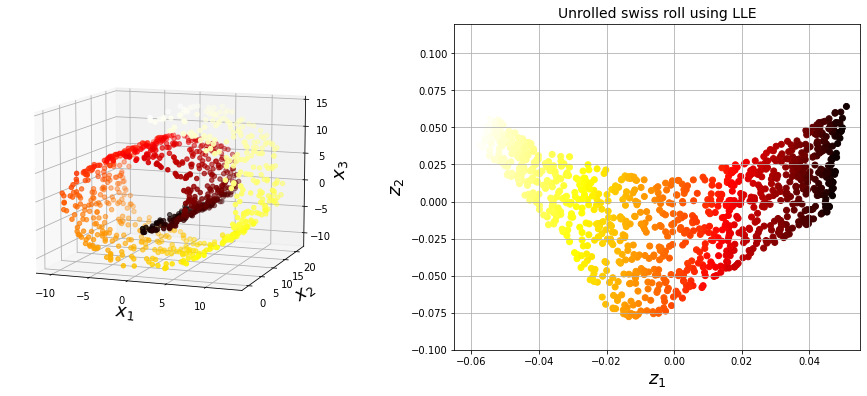

In [60]:
# plot swiss roll dataset in 3D and the reduced dataset in 2D
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax1.view_init(10, -70)
ax1.set_xlabel("$x_1$", fontsize=18)
ax1.set_ylabel("$x_2$", fontsize=18)
ax1.set_zlabel("$x_3$", fontsize=18)
ax1.set_xlim(axes[0:2])
ax1.set_ylim(axes[2:4])
ax1.set_zlim(axes[4:6])

ax2 = fig.add_subplot(122)
ax2.scatter(X_reduced_lle[:, 0], X_reduced_lle[:, 1], c=t, cmap=plt.cm.hot)
ax2.set_xlabel("$z_1$", fontsize=18)
ax2.set_ylabel("$z_2$", fontsize=18)
ax2.set_title("Unrolled swiss roll using LLE", fontsize=14)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True);